# AI Community @ Семинар № 8, весна 2018
## Style transfer.

Обратимся к предыдущей тетрадке. В ней мы пытались восстановить текстуру из данного распредления. При этом мы пользовались ошибкой $L = \sum_l w_{style,l} E_{style, l}$. Изменим задачу. Нам так же дают текстуру, но еще добавляют другое изображение $O$. Наша цель перенести стиль изображения-текстуры на изображение О.

Пример:
<img src='images/starry_night_transfer.png'>
<div style="text-align: right"><font size="2">Изображение из статьи [1]</font></div>

Так же изменим функцию ошибки, а именно добавим часть, которая будут отвечать за оригинал изображения:
$$E_{content,k} = w_{content} \sum_{i,j} (F_{content}^k - F_{gen}^k)^2\,\,\,\,\,(1)$$, где $F_{content}^k$ - сохраненная карта признаков оригинального изображения $O$ на слое $k$, $F_{gen}^k$ - карта признаков генерируемого изображения на слое $k$, $w_{content}$ - вес изображения $O$ в финальном лоссе. Тогда:
$$L = (\sum_l w_{style,l} E_{style, l}) + E_{content,k}$$, где $k$ - номер слоя из которого будет извлекаться представление изображения $O$.   
Это значение мы и будем оптимизировать.  
Разберем реализацию на PyTorch из [этого туториала](https://pytorch.org/tutorials/advanced/neural_style_tutorial.html) от [Alexis Jacq](https://alexis-jacq.github.io/):

In [1]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [2]:
# Выбираем девайс, на котором будем запускать сеть
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Загрузим исходные изображения предварительно отмасштабировав их в отрезок [0; 1]

In [3]:
# desired size of the output image
imsize = (512, 512) if torch.cuda.is_available() else (128, 128)  # use small size if no gpu

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor and scale into range [0; 1]


def image_loader(image_name, size=None):
    image = Image.open(image_name)

    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

style_img1 = image_loader("images/style3.jpg")
style_img2 = image_loader("images/style2.jpg")
content_img = image_loader("images/content3.jpg")

assert style_img1.size() == content_img.size() and style_img2.size() == content_img.size(), \
    "we need to import style and content images of the same size"

Определим функцию отрисовки изображений. Так как сеть оперирует изображениям-тезорами принимающими значения от 0 до 1, для их отриосовки нам необходимо отмасштабировать их обратно на отрезок [0; 255]

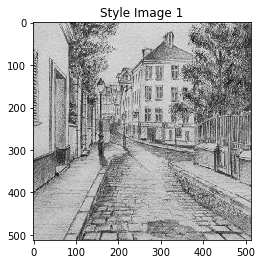

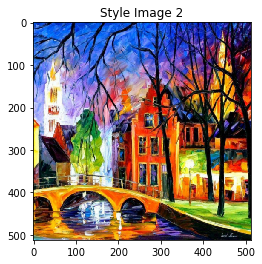

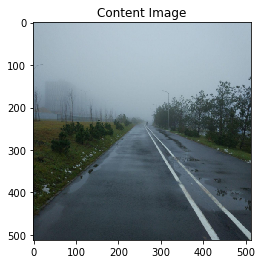

In [5]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img1, title='Style Image 1')

plt.figure()
imshow(style_img2, title='Style Image 2')

plt.figure()
imshow(content_img, title='Content Image')

Напишем модуль для вычисления ошибки генерируемого изображения в отношении оригинала. При инициализации сохраним карту признаков соответствующего слоя, определим функцию ошибки. Здесь используется средне квадратичная ошибка. Так как изображение прогоняется одно, $MSE$ будет эквивалентно $L_2^2$.

Здесь и далее используется функция detach(). Сеть в PyTorch представлена в виде вычислительного графа. Вычисляются при вызове модуля все вершины, которые в этом графе находятся. Функция detach() возвращает torch.Variable, вырванный из основного графа, который больше не участвует в вычислениях и не требует градиента.

In [6]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.clone().detach()

    def forward(self, input_tensor):
        self.loss = F.mse_loss(input_tensor, self.target)
        return input_tensor

Также определим функцию для подсчета матрицы Грама. Матрица Грама получается путём умножения матрицы $F$ на её транспонированную версию $F^T$. В нашем случае матрица $F$ - это изменённая версия выхода на определённом слое $L$. Выход на слое $L$ имеет размерность $[N,C,H, W]$. Его нужно перевести в форму размерности $[N*C, H*W]$. Затем полученную матрицу Грама нужно нормализовать делением на общее количество элементов в ней. Это препятсвует большему вкладу матриц с большими размерностями во время градиентного спуска.

In [7]:
def gram_matrix(input_tensor):
    a, b, c, d = input_tensor.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input_tensor.view(a * b, c * d)  # resise

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

Модуль StyleLoss очень похож на модуль ContentLoss. Но тут уже сохраняем соответсвующую матрицу Грэма(в target передается уже посчитанная матрица), чтобы в будущем сравнивать с ней новые матрицы полученные на очередном прогоне.  Для подсчёта расстояния так же используется $MSE$.

In [8]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).clone().detach()

    def forward(self, input_tensor):
        G = gram_matrix(input_tensor)
        self.loss = F.mse_loss(G, self.target)
        return input_tensor

In [9]:
class MultipleStyleLoss(nn.Module):

    def __init__(self, target_features, style_weights):
        super(MultipleStyleLoss, self).__init__()
        
        target = None
        style_weights = torch.Tensor(style_weights)
        style_weights = style_weights/torch.sum(style_weights)
        for target_feature, style_weight in zip(target_features, style_weights):
            weighted_gram = gram_matrix(target_feature).clone().detach() * style_weight
            if target is None:
                target = weighted_gram.clone()
            else:
                target += weighted_gram
        self.target = target

    def forward(self, input_tensor):
        G = gram_matrix(input_tensor)
        self.loss = F.mse_loss(G, self.target)
        return input_tensor

Выделим из претренированной VGG 19 сверточные и pooling слои

In [19]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

Эта VGG сеть обучена на изображениях с нормализацией mean=[0.485, 0.456, 0.406] и std=[0.229, 0.224, 0.225]. Эта нормализация будет использоваться в дальнейшем для подачи изображений в сеть

In [20]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

Эта с виду страшная функция(заметим, что в основной код в этой функции это один и тот же фрагмент) создает на основе VGG 19 новую сеть:
1. В новую модель добавим все, что было в VGG
2. Если в переменной content_layers перечислен данный слой, то добавим после него, в виде отдельной ветви, модуль ContentLoss. От этого значения в будущем будет считаться градиент. Также сохраним ссылку на этот модуль в content_losses, понадобится для вычисления градиента.
3. Точно так же, если в переменной style_layers перечислен данный слой, то добавим после него, в виде отдельной ветви, модуль StyleLoss. От этого значения также в будущем будет считаться градиент. Также сохраним ссылку на этот модуль в style_losses, понадобится для вычисления градиента.

In [21]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_imgs, style_weights, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
# def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
#                                style_img, content_img,
#                                content_layers=content_layers_default,
#                                style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_features = []
            for style_img in style_imgs:
                target_feature = model(style_img).detach()
                target_features.append(target_feature)
            style_loss = MultipleStyleLoss(target_features, style_weights)

#             target_feature = model(style_img).detach()
#             style_loss = StyleLoss(target_feature)
        
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], MultipleStyleLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

Инициализируем изображение, кторое будем изменять. Здесь есть два варианта:
1. Сгенерировать случайный шум.
2. Использовать изображение-оригинал

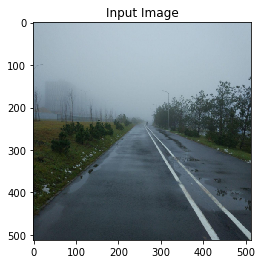

In [22]:
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

При оптимизации будем использовать метод оптимизации L-BFGS. Так посоветовал автор статьи [здесь.](https://discuss.pytorch.org/t/pytorch-tutorial-for-neural-transfert-of-artistic-style/336/20?u=alexis-jacq)

In [23]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

И наконец, аналогично texture synthesis, минимизируем функцию ошибки. В результате input_img будет содержать желаемое изображение с новым стилем.

In [24]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_imgs, style_weights, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
# def run_style_transfer(cnn, normalization_mean, normalization_std,
#                        content_img, style_img, input_img, num_steps=300,
#                        style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_imgs, style_weights, content_img)
#     model, style_losses, content_losses = get_style_model_and_losses(cnn,
#         normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

И финальный шаг! Запустим процесс переноса стиля и получим долгожданное изображение в стиле картин художников.

Building the style transfer model..


D:\Anaconda\envs\id-tracker\lib\site-packages\ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
D:\Anaconda\envs\id-tracker\lib\site-packages\ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


Optimizing..
run [50]:
Style Loss : 276.683990 Content Loss: 31.075640

run [100]:
Style Loss : 79.497566 Content Loss: 30.895048

run [150]:
Style Loss : 26.386309 Content Loss: 30.371468

run [200]:
Style Loss : 10.330430 Content Loss: 29.281754

run [250]:
Style Loss : 5.357088 Content Loss: 27.868267

run [300]:
Style Loss : 3.355709 Content Loss: 26.469090

run [350]:
Style Loss : 2.336518 Content Loss: 25.335644

run [400]:
Style Loss : 1.817719 Content Loss: 24.365793



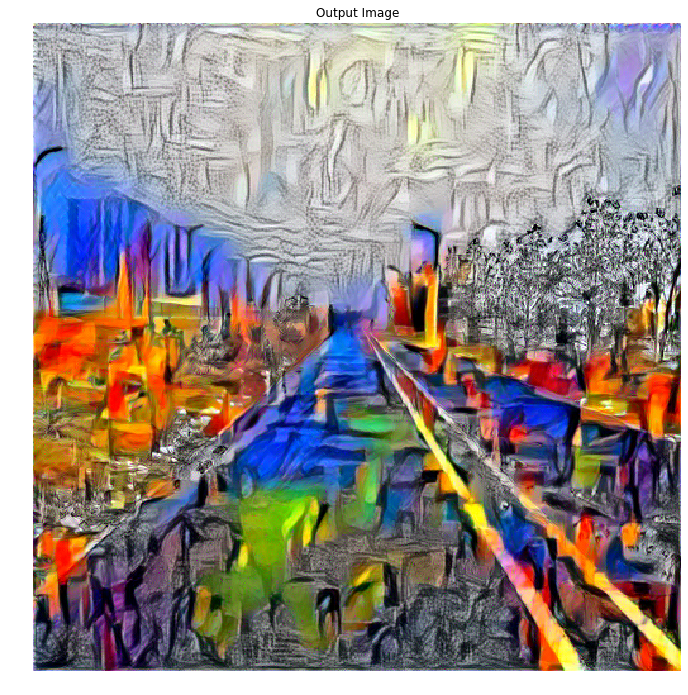

In [25]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, [style_img1, style_img2], [0.5, 0.5], input_img, num_steps=400)
# output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
#                             content_img, style_img1, input_img, num_steps=400)

fig_size = 9

_, _, height, width = output.shape
fig = plt.figure()
fig.set_size_inches(width / height * fig_size, fig_size, forward=True)
ax = plt.Axes(fig, [0., 0., 1, 1])
ax.set_axis_off()
fig.add_axes(ax)

imshow(output, title='Output Image')
# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

Ссылки:
1. [Статья на arxiv](https://arxiv.org/abs/1508.06576)
2. [Презентация cs231n](http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture12.pdf)
3. [Статья про сохранение цвета(arxiv)](https://arxiv.org/pdf/1606.05897.pdf)
4. [Статья про тренировку отдельной сети для style transfer (arxiv)](https://arxiv.org/abs/1603.08155)